In [20]:
import tensorflow as tf
from censai.definitions import log_10
from censai.models import VAE
from astropy.visualization import ImageNormalize, LogStretch
from censai.data.kappa_tng import decode_train
from censai.data.cosmos import decode_image, decode_shape, preprocess_image
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LogNorm
from censai import PhysicalModel
import json, os, glob
from argparse import Namespace
import h5py

import matplotlib.pylab as pylab
plt.style.use("science") # requires SciencePlots
params = {'legend.fontsize': 27,
          'figure.figsize': (10, 10),
         'axes.labelsize': 37,
         'axes.titlesize': 37,
         'xtick.labelsize':35,
         'ytick.labelsize':35,
         'figure.titlesize': 40,
          'xtick.major.size': 8,
          'xtick.minor.size': 4,
         'xtick.major.width': 1,
          'xtick.minor.width': 1,
         'ytick.major.size': 8,
          'ytick.minor.size': 4,
         'ytick.major.width': 1,
          'ytick.minor.width': 1,

         }
pylab.rcParams.update(params)

In [3]:
hf = h5py.File(os.path.join(os.getenv("CENSAI_PATH"), "results", "final_results_likelihood_ewc_optim_lr1e-6_lam2e5.h5"), "r")

In [18]:
kvae_path = os.path.join(os.getenv('CENSAI_PATH2'), "models", "VAE1_128hstfr_002_LS16_dr0.7_betaE0.2_betaDS5000_211115153537")

with open(os.path.join(kvae_path, "script_params.json"), "r") as f:
    kargs = json.load(f)
kargs = Namespace(**kargs)
with open(os.path.join(kvae_path, "model_hparams.json"), "r") as f:
    kappa_vae_hparams = json.load(f)
kappa_vae = VAE(**kappa_vae_hparams)
ckpt1 = tf.train.Checkpoint(step=tf.Variable(1), net=kappa_vae)
checkpoint_manager1 = tf.train.CheckpointManager(ckpt1, kvae_path, 1)
checkpoint_manager1.checkpoint.restore(checkpoint_manager1.latest_checkpoint).expect_partial()

svae_path = os.path.join(os.getenv('CENSAI_PATH2'), "models","VAE1_COSMOSFR_001_F16_NLleaky_relu_LS32_betaE0.1_betaDS100000_220112114306")

with open(os.path.join(svae_path, "script_params.json"), "r") as f:
    gargs = json.load(f)
gargs = Namespace(**gargs)
with open(os.path.join(svae_path, "model_hparams.json"), "r") as f:
    source_vae_hparams = json.load(f)
source_vae = VAE(**source_vae_hparams)
ckpt2 = tf.train.Checkpoint(step=tf.Variable(1), net=source_vae)
checkpoint_manager2 = tf.train.CheckpointManager(ckpt2, svae_path, 1)
checkpoint_manager2.checkpoint.restore(checkpoint_manager2.latest_checkpoint).expect_partial()
wk = lambda k: tf.sqrt(k) / tf.reduce_sum(tf.sqrt(k), axis=(1, 2, 3), keepdims=True)

In [5]:
ell = 1396
n_samples = 6
sigma = 0.5

chisq_ro = hf["chi_squared_reoptimized"][:]
indices = np.argsort(chisq_ro)
phys = PhysicalModel(pixels=128, src_fov=3, image_fov=7.69, kappa_fov=7.69, method="fft")

# set seed to the same it was in reoptimisation script
tf.random.set_seed(42)
np.random.seed(42)
j = indices[ell]
lens = hf[f"observation"][j].squeeze()
source = hf[f"source"][j].squeeze()
kappa = hf[f"kappa"][j].squeeze()
lens_pred = hf[f"observation_pred"][j].squeeze()
source_pred = hf[f"source_pred"][j][-1][None, ...] # baseline predictions
kappa_pred = hf[f"kappa_pred"][j][-1][None, ...]
chi_squared = hf["chi_squared_reoptimized"][j]
noise_rms = hf["noise_rms"][j]
psf = hf["psf"][j][None, ...]

# Latent code of model predictions
z_source, _ = source_vae.encoder(source_pred)
z_kappa, _ = kappa_vae.encoder(log_10(kappa_pred))

source_samples = []
kappa_samples = []
obs_samples = []
for n in range(n_samples):
    # Sample latent code around the prediction mean
    z_s = tf.random.normal(shape=[1, source_vae.latent_size], mean=z_source, stddev=sigma)
    z_k = tf.random.normal(shape=[1, kappa_vae.latent_size], mean=z_kappa, stddev=sigma)
    # Decode
    sampled_source = tf.nn.relu(source_vae.decode(z_s))
    sampled_source /= tf.reduce_max(sampled_source, axis=(1, 2, 3), keepdims=True)
    sampled_kappa = kappa_vae.decode(z_k)  # output in log_10 space
    # Simulate observation
    sampled_observation = phys.noisy_forward(sampled_source, 10 ** sampled_kappa, noise_rms, psf)
    
    source_samples.append(sampled_source)
    kappa_samples.append(sampled_kappa)
    obs_samples.append(sampled_observation)

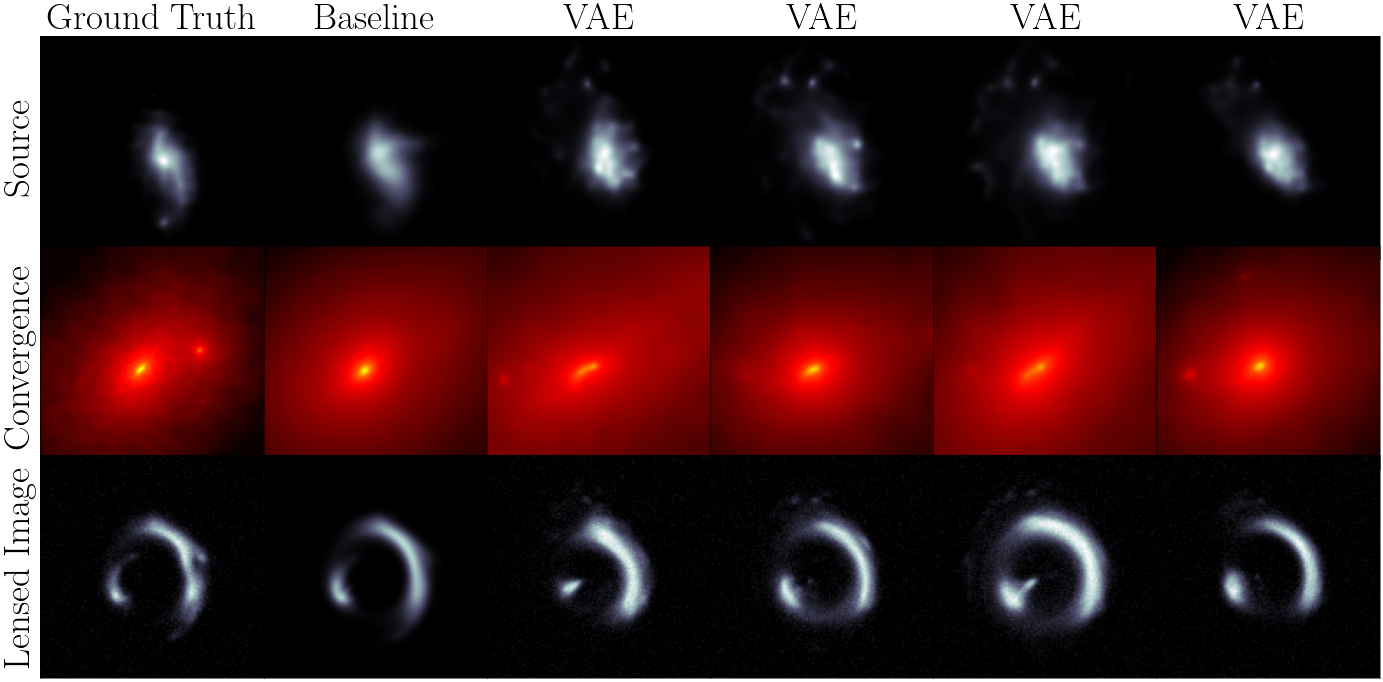

In [6]:
N = 4
fig, axs = plt.subplots(3, N+2, figsize=(4 * N + 8, 12), facecolor="w")
a = 100
i_min = 1e-2
# i_norm = ImageNormalize(stretch=LogStretch(a), vmin=i_min, vmax=1)
intensity_cmap="bone"
i_norm = ImageNormalize(vmin=0, vmax=1)

for j in range(N+2):            
    for i in range(3):
        axs[i, j].get_xaxis().set_ticks([])
        axs[i, j].get_yaxis().set_ticks([])

for i in range(2, N+2):
    axs[0, i].imshow(source_samples[i][0, ..., 0], cmap=intensity_cmap, norm=i_norm, origin="lower")
    axs[0, i].set_title("VAE")
    axs[1, i].imshow(10**kappa_samples[i][0, ..., 0], cmap="hot", norm=LogNorm(vmin=1e-1, vmax=100), origin="lower")
    axs[2, i].imshow(obs_samples[i][0, ..., 0], cmap=intensity_cmap, norm=i_norm, origin="lower")
    
axs[0, 0].imshow(source, cmap=intensity_cmap, norm=i_norm, origin="lower")
axs[1, 0].imshow(kappa, cmap="hot", norm=LogNorm(vmin=1e-1, vmax=100), origin="lower")
axs[2, 0].imshow(lens, cmap=intensity_cmap, norm=i_norm, origin="lower")
axs[0, 0].set_title("Ground Truth")

axs[0, 1].imshow(source_pred[0, ..., 0], cmap=intensity_cmap, norm=i_norm, origin="lower")
axs[1, 1].imshow(kappa_pred[0, ..., 0], cmap="hot", norm=LogNorm(vmin=1e-1, vmax=100), origin="lower")
axs[2, 1].imshow(lens_pred, cmap=intensity_cmap, norm=i_norm, origin="lower")
axs[0, 1].set_title("Baseline")



axs[0, 0].set_ylabel("Source")
axs[1, 0].set_ylabel("Convergence")
axs[2, 0].set_ylabel("Lensed Image")
plt.subplots_adjust(wspace=0, hspace=-0.1)
# plt.savefig("../../Censai-paper/figures/vae_samples_similar_to_highlight")

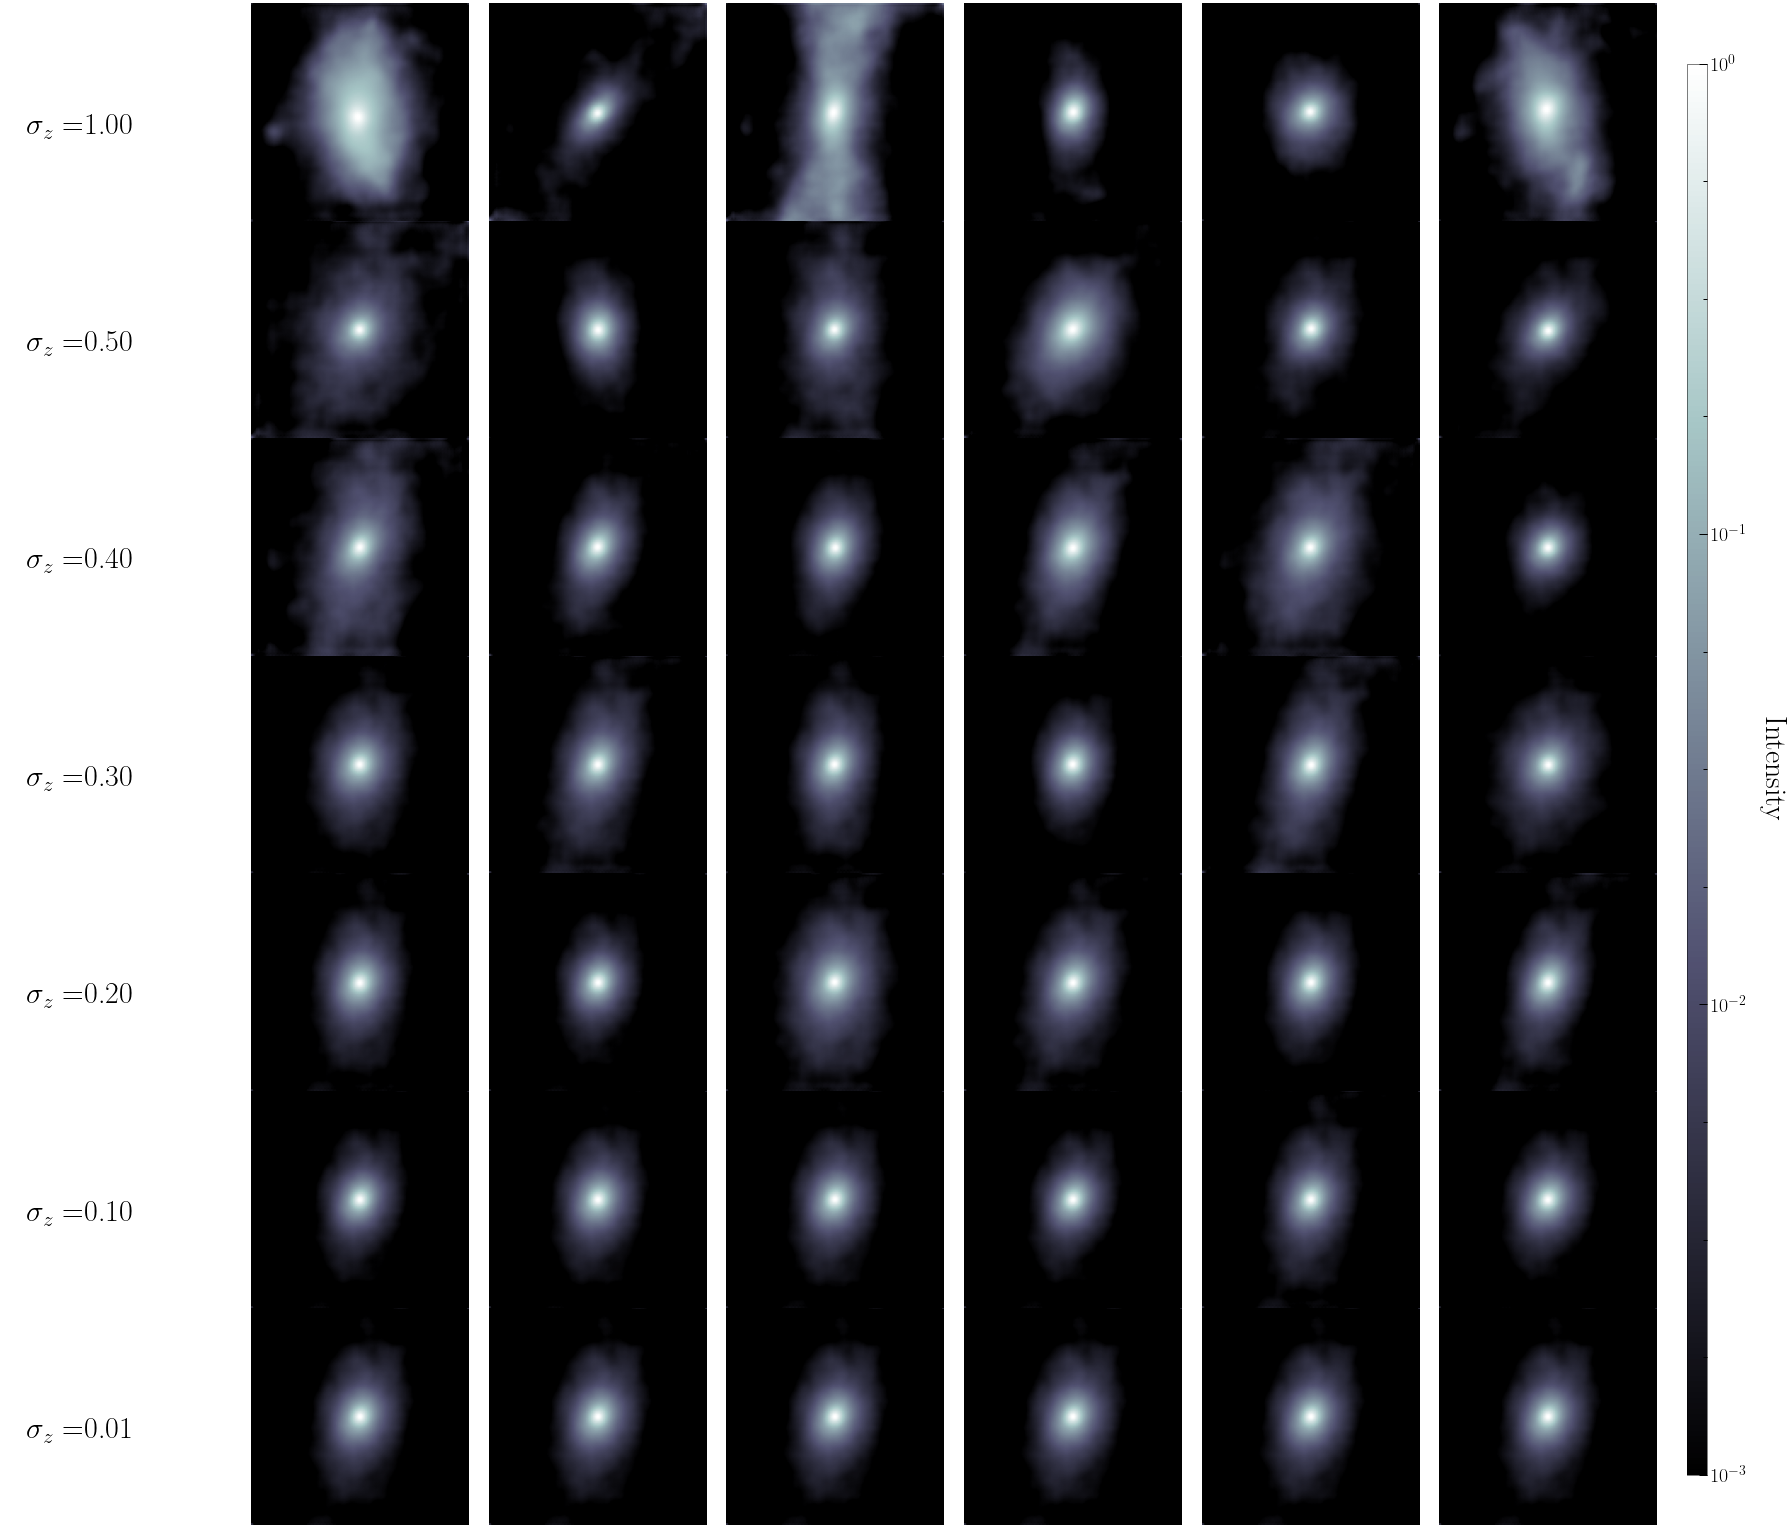

In [12]:
ball_size = [1, 0.5, 0.4, 0.3, 0.2, 0.1, 0.01]
mean = tf.random.normal(shape=(1, source_vae.latent_size))

cmap = "bone"
fig, axs = plt.subplots(len(ball_size), 7, figsize=(4*7, 4*len(ball_size)))
for i, b in enumerate(ball_size):
    z = tf.random.normal(shape=(10, source_vae.latent_size), mean=mean, stddev=b)
    sim_gal = tf.nn.relu(source_vae.decode(z))
    sim_gal /= tf.reduce_max(sim_gal, keepdims=True)
    for j in range(6):
        axs[i, j+1].imshow(sim_gal[j, ..., 0], cmap=cmap, norm=ImageNormalize(stretch=LogStretch(), vmin=1e-3, vmax=1))
        axs[i, j+1].axis("off")
    axs[i, 0].axis("off")
    axs[i, 0].annotate(rf"$\sigma_z = ${b:.2f}", (0.1, 0.4), xycoords="axes fraction", fontsize=30)

        
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.96, 0.15, 0.01, 0.7])
fig.colorbar(ScalarMappable(cmap=cmap, norm=ImageNormalize(stretch=LogStretch(), vmin=1e-3, vmax=1)), cax=cbar_ax, ticks=[0.001, 0.01, 0.1, 1.])
cbar_ax.set_yticklabels(["$10^{-3}$", "$10^{-2}$", "$10^{-1}$", "$10^{0}$"], fontsize=20) 
cbar_ax.set_ylabel(r"Intensity", rotation=270, labelpad=40, fontsize=30)
cbar_ax.yaxis.set_label_position("right")
plt.subplots_adjust(wspace=0, hspace=0)
# plt.savefig("gal_vae_region_sampling.png", facecolor="white")

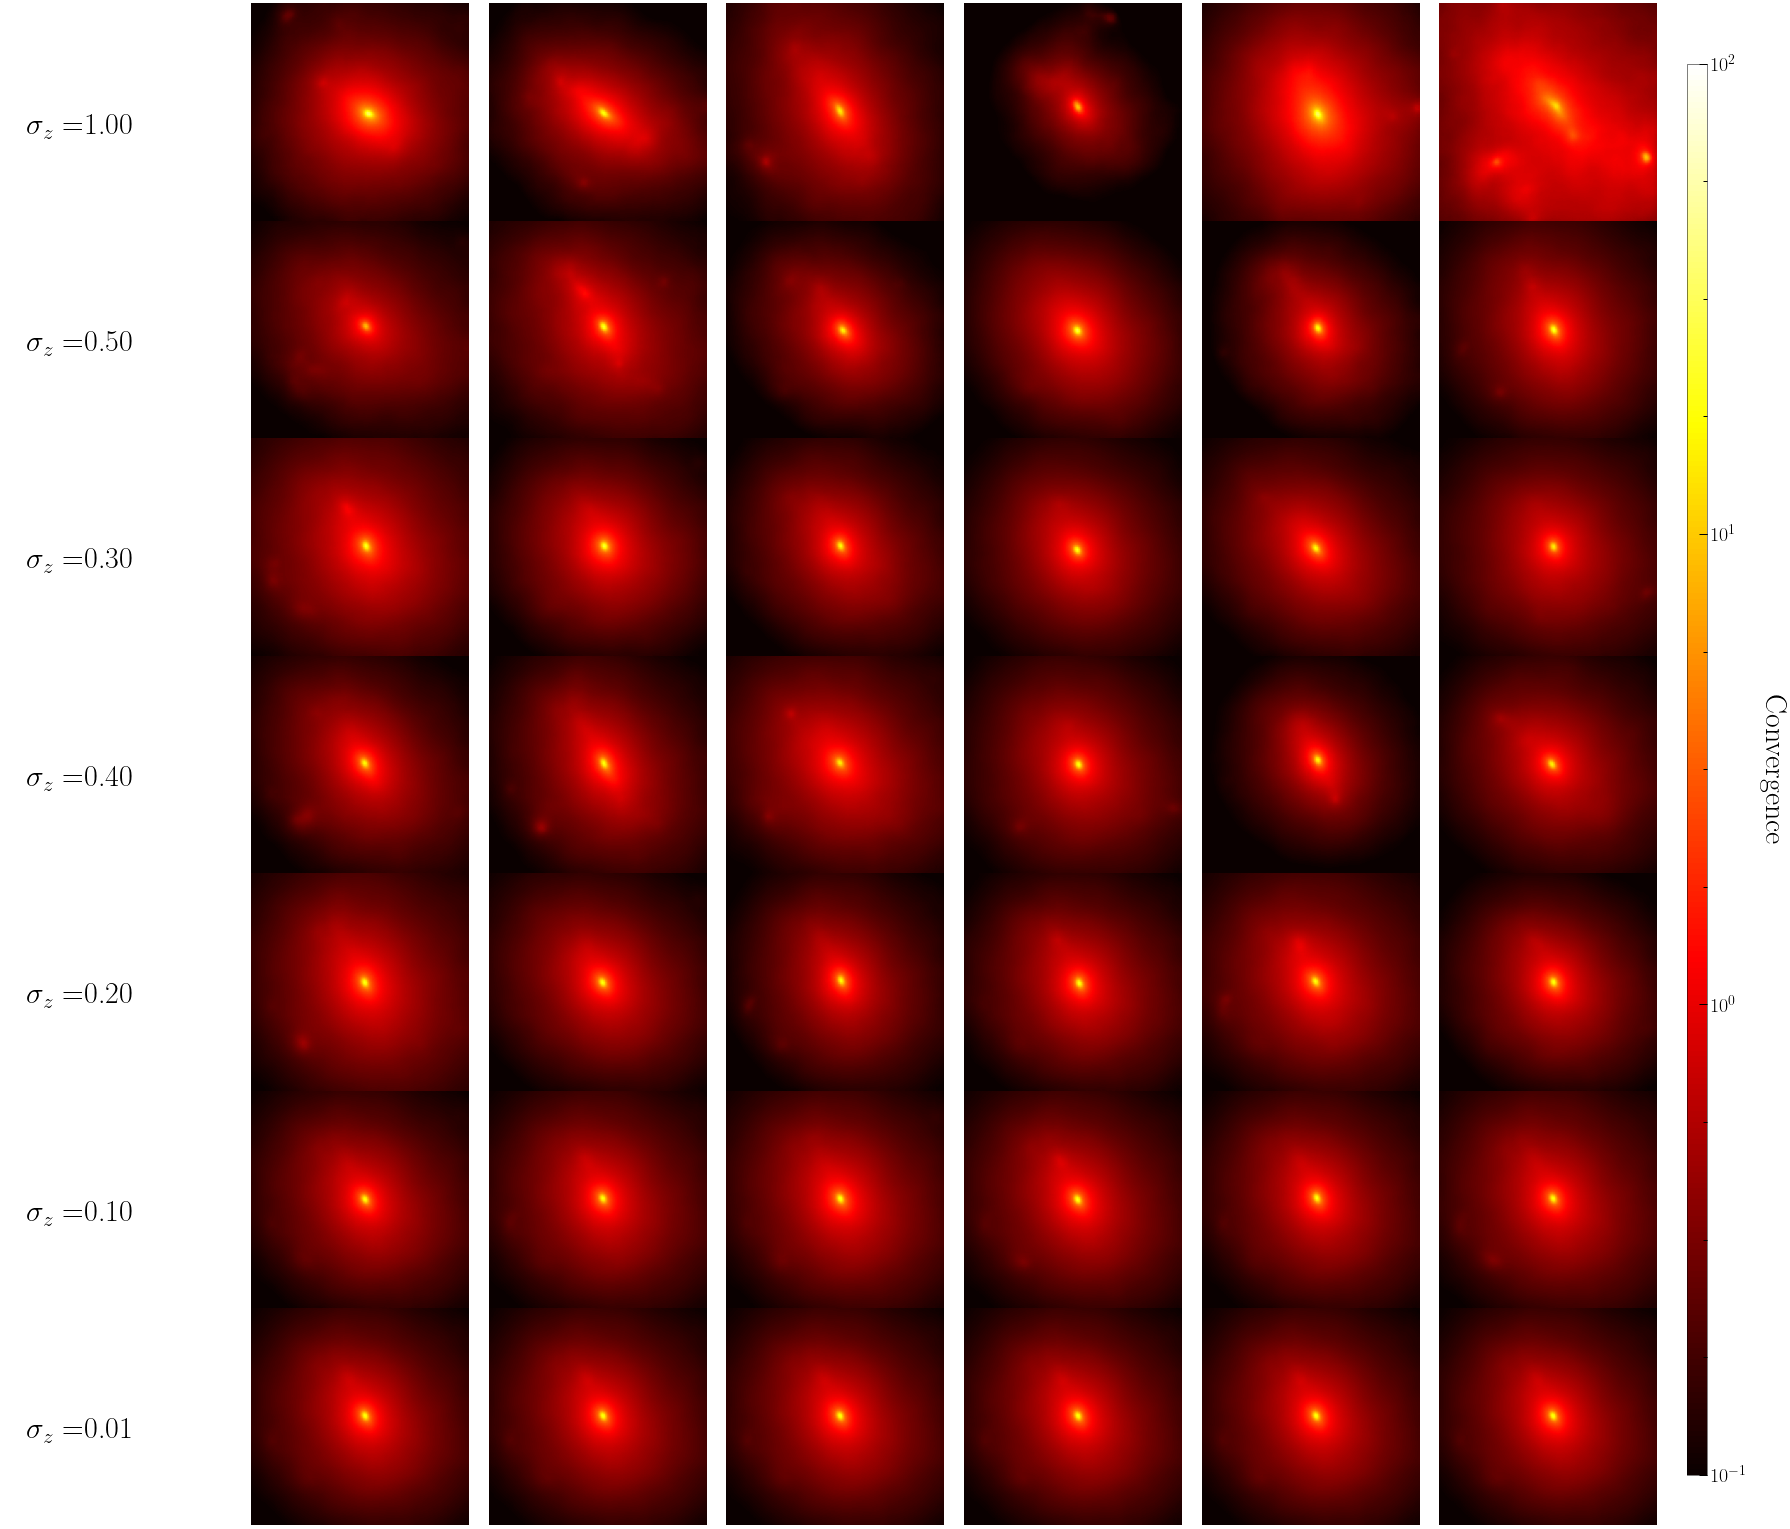

In [13]:

ball_size = [1, 0.5, 0.3, 0.4, 0.2, 0.1, 0.01]
mean = tf.random.normal(shape=(1, kappa_vae.latent_size))

cmap = "hot"
fig, axs = plt.subplots(len(ball_size), 7, figsize=(4*7, 4*len(ball_size)))
for i, b in enumerate(ball_size):
    z = tf.random.normal(shape=(10, kappa_vae.latent_size), mean=mean, stddev=b)
    sim_kap = kappa_vae.decode(z)
    for j in range(6):
        axs[i, j+1].imshow(10**sim_kap[j, ..., 0], cmap=cmap, norm=ImageNormalize(stretch=LogStretch(), vmin=1e-1, vmax=100))
        axs[i, j+1].axis("off")
    axs[i, 0].axis("off")
    axs[i, 0].annotate(rf"$\sigma_z = ${b:.2f}", (0.1, 0.4), xycoords="axes fraction", fontsize=30)

        
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.96, 0.15, 0.01, 0.7])
fig.colorbar(ScalarMappable(cmap=cmap, norm=ImageNormalize(stretch=LogStretch(), vmin=1e-1, vmax=100)), cax=cbar_ax, ticks=[0.1, 1, 10, 100])
cbar_ax.set_yticklabels(["$10^{-1}$", "$10^{0}$", "$10^{1}$", "$10^{2}$"], fontsize=20) 
cbar_ax.set_ylabel(r"Convergence", rotation=270, labelpad=40, fontsize=30)
cbar_ax.yaxis.set_label_position("right")
plt.subplots_adjust(wspace=0, hspace=0)
# plt.savefig("kap_vae_region_sampling.png", facecolor="white")

In [22]:
gal_dataset_path = "/media/alexandre/Seagate/Ecole/Censai/data/cosmos_23.5_finalrun_train"
kap_dataset_path = "/media/alexandre/Seagate/Ecole/Censai/data/hkappa128hst_TNG100_rau_trainset"

sample_size = 7

files = glob.glob(os.path.join(kap_dataset_path, "*.tfrecords"))
np.random.shuffle(files)
files = tf.data.Dataset.from_tensor_slices(files)
kap_dataset = files.interleave(lambda x: tf.data.TFRecordDataset(x, compression_type=kargs.compression_type).shuffle(10), block_length=kargs.block_length, num_parallel_calls=tf.data.AUTOTUNE)
kap_dataset = kap_dataset.map(decode_train).shuffle(100).batch(sample_size)


files = glob.glob(os.path.join(gal_dataset_path, "*.tfrecords"))
np.random.shuffle(files)
files = tf.data.Dataset.from_tensor_slices(files)
dataset = files.interleave(lambda x: tf.data.TFRecordDataset(x, compression_type=gargs.compression_type).shuffle(10), block_length=gargs.block_length, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.map(decode_image).map(preprocess_image).shuffle(100).batch(sample_size)

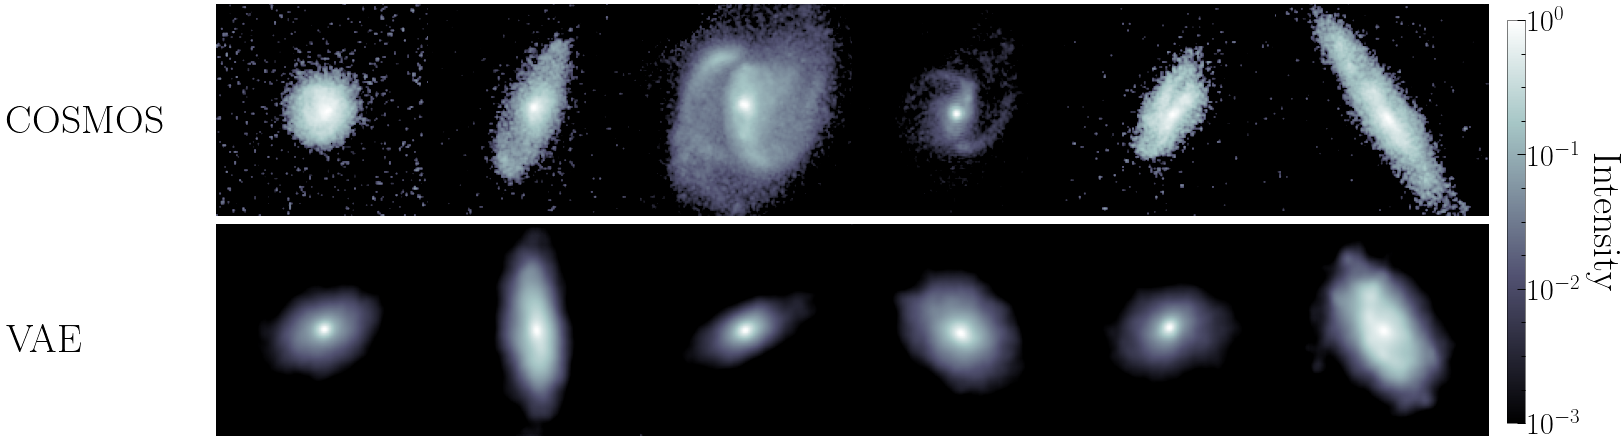

In [80]:
cmap = "bone"
label_color = "k"
fig, axs = plt.subplots(2, 7, figsize=(25, 8))
for gal in dataset:
    break
sim_gal = preprocess_image(source_vae.sample(sample_size))

for j in range(6):
    axs[0, j+1].imshow(gal[j, ..., 0], cmap=cmap, norm=ImageNormalize(stretch=LogStretch(), vmin=1e-3, vmax=1))
    axs[0, j+1].axis("off")
for j in range(6):
    axs[1, j+1].imshow(sim_gal[j, ..., 0], cmap=cmap, norm=ImageNormalize(stretch=LogStretch(), vmin=1e-3, vmax=1))
    axs[1, j+1].axis("off")
axs[0, 0].axis("off")
axs[0, 0].annotate("COSMOS", (0.01, 0.4), xycoords="axes fraction", fontsize=40, color=label_color)
axs[1, 0].axis("off")
axs[1, 0].annotate("VAE", (0.01, 0.4), xycoords="axes fraction", fontsize=40, color=label_color)

fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.96, 0.15, 0.01, 0.7])
fig.colorbar(ScalarMappable(cmap=cmap, norm=ImageNormalize(stretch=LogStretch(), vmin=1e-3, vmax=1)), cax=cbar_ax, ticks=[0.001, 0.01, 0.1, 1.])
cbar_ax.set_yticklabels(["$10^{-3}$", "$10^{-2}$", "$10^{-1}$", "$10^{0}$"], fontsize=30, color=label_color) 
cbar_ax.set_ylabel(r"Intensity", rotation=270, labelpad=40, fontsize=40, color=label_color)
cbar_ax.yaxis.set_label_position("right")
plt.subplots_adjust(wspace=0, hspace=0.02)
plt.savefig("gal_vae_sample.png")

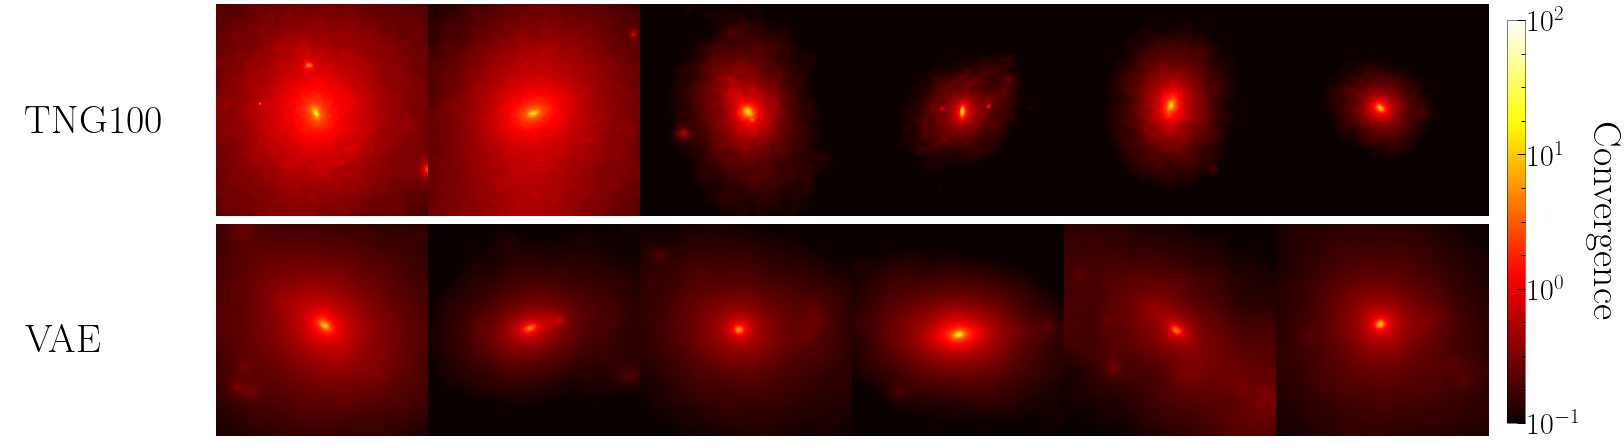

In [87]:
cmap = "hot"
label_color = "k"

fig, axs = plt.subplots(2, 7, figsize=(25, 8))
for kap in kap_dataset:
    break
sim_kap = 10**kappa_vae.sample(sample_size)

for j in range(6):
    axs[0, j+1].imshow(kap[j, ..., 0], cmap=cmap, norm=ImageNormalize(stretch=LogStretch(), vmin=1e-1, vmax=100))
    axs[0, j+1].axis("off")
for j in range(6):
    axs[1, j+1].imshow(sim_kap[j, ..., 0], cmap=cmap, norm=ImageNormalize(stretch=LogStretch(), vmin=1e-1, vmax=100))
    axs[1, j+1].axis("off")
axs[0, 0].axis("off")
axs[0, 0].annotate("TNG100", (0.1, 0.4), xycoords="axes fraction", fontsize=40, color=label_color)
axs[1, 0].axis("off")
axs[1, 0].annotate("VAE", (0.1, 0.4), xycoords="axes fraction", fontsize=40, color=label_color)

fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.96, 0.15, 0.01, 0.7])
fig.colorbar(ScalarMappable(cmap=cmap, norm=ImageNormalize(stretch=LogStretch(), vmin=1e-1, vmax=100)), cax=cbar_ax, ticks=[0.1, 1, 10, 100])
cbar_ax.set_yticklabels(["$10^{-1}$", "$10^{0}$", "$10^{1}$", "$10^{2}$"], fontsize=30, color=label_color) 
cbar_ax.set_ylabel(r"Convergence", rotation=270, labelpad=40, fontsize=40, color=label_color)
cbar_ax.yaxis.set_label_position("right")
plt.subplots_adjust(wspace=0, hspace=0.02)
plt.savefig("kap_vae_sample.png")